In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import tikzplotlib
import seaborn as sns

import json
from datetime import datetime

In [29]:
projects_df = pd.read_csv('/root/data2/projects.csv',
                         parse_dates=['project_created_at', 'project_last_pushed_at', 'project_updated_at'])
projects_df['project_revision'] = projects_df.apply(lambda x: x['project_revision'][:10], axis=1)

In [3]:
packages_df = pd.read_csv('/root/data2/packages_0_499.csv').dropna()

In [4]:
geiger_df = pd.read_csv('/root/data2/geiger/geiger_findings_0_499.csv')

In [114]:
sampled_usages_app = pd.read_csv('/root/data/classification/sampled_usages_app.csv')
sampled_usages_std = pd.read_csv('/root/data/classification/sampled_usages_std.csv')

# Research question answers

In [9]:
mdf = pd.merge(packages_df, projects_df, how='left', on='project_name', validate='many_to_one')

df1 = mdf\
    [(mdf['module_path']==mdf['project_root_module'])&(mdf['is_standard']==False)]\
    .groupby('project_name')['package_unsafe_sum']\
    .agg(project_unsafe_pkg_count=lambda x: np.count_nonzero(x))\
    .reset_index()\
    .sort_values(by='project_unsafe_pkg_count', ascending=False)
                
df2 = mdf\
    [(mdf['module_path']!=mdf['project_root_module'])&(mdf['is_standard']==False)]\
    .groupby('project_name')['package_unsafe_sum']\
    .agg(dep_unsafe_pkg_count=lambda x: np.count_nonzero(x))\
    .reset_index()
                 
df = pd.merge(df1, df2, how='left', on='project_name', validate='one_to_one').fillna(0)
df['total_unsafe_pkg_count'] = df.apply(lambda x: x['project_unsafe_pkg_count'] + x['dep_unsafe_pkg_count'], axis=1)

projects_count = df['project_name'].count()

unsafe_project_count = df[df['project_unsafe_pkg_count']>0]['project_name'].count()
unsafe_dep_count = df[df['dep_unsafe_pkg_count']>0]['project_name'].count()
unsafe_total_count = df[df['total_unsafe_pkg_count']>0]['project_name'].count()

print("#projects: {}".format(projects_count))
print("projects with >=1 unsafe project package: {} ({:.2%})".format(unsafe_project_count, unsafe_project_count/projects_count))
print("projects with >=1 unsafe dependency (no std): {} ({:.2%})".format(unsafe_dep_count, unsafe_dep_count/projects_count))
print("projects with >=1 unsafe anywhere (no std): {} ({:.2%})".format(unsafe_total_count, unsafe_total_count/projects_count))

#projects: 343
projects with >=1 unsafe project package: 131 (38.19%)
projects with >=1 unsafe dependency (no std): 299 (87.17%)
projects with >=1 unsafe anywhere (no std): 312 (90.96%)


In [175]:
df = packages_df\
    .drop_duplicates(subset=['import_path', 'dir', 'module_path', 'module_version'])

packages_count = df['name'].count()
unsafe_packages_count = df[df['package_unsafe_sum']>0]['name'].count()

print("{} of {} ({:.2%}) transitively imported packages use unsafe".format(unsafe_packages_count, packages_count,
                                                                    unsafe_packages_count/packages_count))

3388 of 62025 (5.46%) transitively imported packages use unsafe


In [176]:
df = packages_df\
    [packages_df['is_standard']==True]\
    .drop_duplicates(subset=['import_path', 'dir', 'module_path', 'module_version'])

packages_count = df['name'].count()
unsafe_packages_count = df[df['package_unsafe_sum']>0]['name'].count()

print("{} of {} ({:.2%}) transitively imported stdlib packages use unsafe".format(unsafe_packages_count, packages_count,
                                                                    unsafe_packages_count/packages_count))

33 of 186 (17.74%) transitively imported stdlib packages use unsafe


In [173]:
df = packages_df\
    .drop_duplicates(subset=['import_path', 'dir', 'module_path', 'module_version'])

analyzed_packages_count = df['import_path'].count()

print("Total analyzed packages: {}".format(analyzed_packages_count))

Total analyzed packages: 62025


# Distribution of unsafe by token type

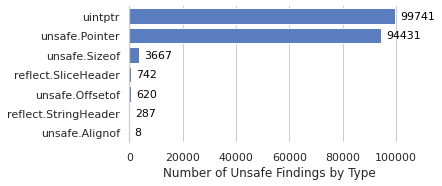

In [110]:
data = packages_df\
    .drop_duplicates(subset=['import_path', 'dir', 'module_path', 'module_version']).dropna()\
    .loc[:,['package_geiger_unsafe_pointer_sum', 'package_geiger_unsafe_sizeof_sum', 'package_geiger_unsafe_offsetof_sum',
           'package_geiger_unsafe_alignof_sum', 'package_geiger_slice_header_sum', 'package_geiger_string_header_sum',
           'package_geiger_uintptr_sum']]\
    .rename(columns={'package_geiger_unsafe_pointer_sum': 'unsafe.Pointer', 'package_geiger_unsafe_sizeof_sum': 'unsafe.Sizeof',
                    'package_geiger_unsafe_offsetof_sum': 'unsafe.Offsetof', 'package_geiger_unsafe_alignof_sum': 'unsafe.Alignof',
                    'package_geiger_slice_header_sum': 'reflect.SliceHeader', 'package_geiger_string_header_sum': 'reflect.StringHeader',
                    'package_geiger_uintptr_sum': 'uintptr'})\
    .sum()\
    .sort_values(ascending=False)

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(5, 2.5))

# Plot the distribution among types
sns.set_color_codes("muted")
g = sns.barplot(data.values, data.index, color="b")

# Add values next to the bars
for p in ax.patches:
    ax.annotate("{}".format(int(p.get_width())), (p.get_width(), p.get_y() + p.get_height() / 2.0),
                ha='left', va='center', fontsize=11, color='black', xytext=(5, 0),
                textcoords='offset points')
#_ = g.set_xlim(0, 120000) #To make space for the annotations

# Add a legend and informative axis label
ax.set(ylabel="", xlabel="Number of Unsafe Findings by Type")
sns.despine(bottom=True)

plt.savefig('/root/data/figures/paper/distribution-unsafe-types.png', dpi=600)

# Import depth of unsafe packages

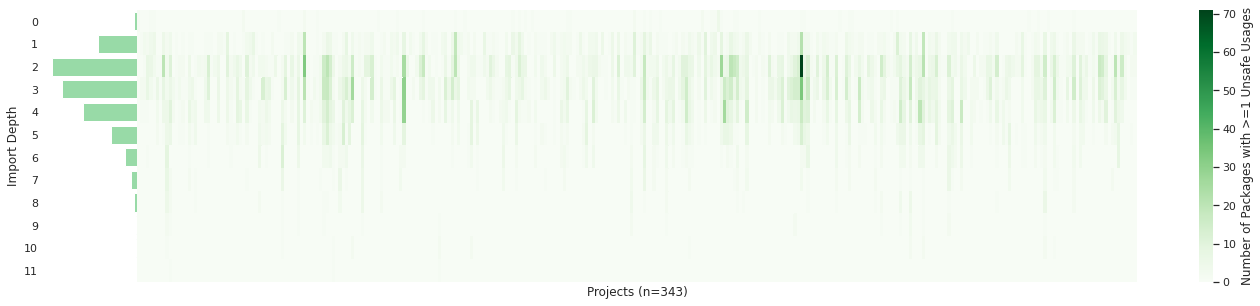

In [97]:
## number of unsafe packages (without std) over hop count

df = packages_df\
    [(packages_df['is_standard']==False)&(packages_df['package_unsafe_sum']>0)]\
    .groupby(['project_name', 'package_hop_count'])['package_unsafe_sum'].count()\
    .unstack().fillna(0).T

distribution_df = packages_df\
    [(packages_df['is_standard']==False)&(packages_df['package_unsafe_sum']>0)]\
    .groupby('package_hop_count')['package_unsafe_sum'].count().T

sns.set(style="white")

# create plot setup
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(24, 5), gridspec_kw={'width_ratios': [1, 14]})
fig.subplots_adjust(wspace=0)

# plot heatmap
sns.heatmap(df, ax=axs[1], cmap='Greens', cbar_kws={'label': 'Number of Packages with >=1 Unsafe Usages'})

# plot distribution
sns.set_color_codes("pastel")
sns.barplot(distribution_df.values, distribution_df.index, orient='h', color="g", ax=axs[0])
axs[0].invert_xaxis()

# labeling
for item in axs[1].get_yticklabels():
    item.set_rotation(0)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set(ylabel="", xlabel="Projects (n={})".format(packages_df['project_name'].nunique()))
axs[0].set(ylabel="Import Depth", xlabel="")
sns.despine(bottom=True, left=True)
axs[0].set_xticks([])

#plt.show()
plt.savefig('/root/data/figures/paper/unsafe-import-depth.png', dpi=1200)

In [11]:
packages_df\
    [(packages_df['is_standard']==False)&(packages_df['package_unsafe_sum']>0)]\
    ['package_hop_count'].describe()

count    5523.000000
mean        3.082021
std         1.620665
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        11.000000
Name: package_hop_count, dtype: float64

# Labeled Set: projects

In [112]:
study_projects_df = packages_df\
    [packages_df['is_standard']==False]\
    .groupby('project_name')['package_unsafe_sum'].sum()\
    .sort_values(ascending=False)\
    .reset_index()[:10]

df = pd.merge(study_projects_df, projects_df, how='left', on='project_name', validate='many_to_one')\
    .loc[:,['project_name', 'project_number_of_stars', 'project_number_of_forks', 'project_revision']]\
    .rename(columns={'project_name': 'Name', 'project_number_of_stars': 'Stars', 'project_number_of_forks': 'Forks',
                    'project_revision': 'Revision'})

df.index = df.index + 1

df
#print(df.to_latex(index=True))

## TODO: add formatters to supply commas in numbers and \texttt{} to revisions

,Name,Stars,Forks,Revision
1,kubernetes/kubernetes,66512,23806,fb9e1946b0
2,elastic/beats,8852,3207,df6f2169c5
3,gorgonia/gorgonia,3373,301,5fb5944d4a
4,weaveworks/scope,4354,554,bf90d56f0c
5,mattermost/mattermost-server,18277,4157,e83cc7357c
6,rancher/rancher,14344,1758,56a464049e
7,cilium/cilium,5501,626,9b0ae85b5f
8,rook/rook,7208,1472,ff90fa7098
9,containers/libpod,4549,539,e8818ced80
10,xo/usql,5871,195,bdff722f7b


# Labeled Set: classes counts table

In [172]:
def number_or_nothing(n):
    if n > 0:
        return str(n).rjust(3)
    else:
        return " "

# for app data set
labels2_in_order_app = ['efficiency', 'generics', 'serialization', 'inevitable', 'safer-reflect', 'layout-control',
                  'escape-analysis-escape', 'unused', 'cgo', 'no-gc']
labels2_abbrev_app = { 'generics': 'gen', 'efficiency': 'eff', 'serialization': 'ser', 'inevitable': 'inev',
                'safer-reflect': 'SR', 'layout-control': 'LC', 'escape-analysis-escape': 'EA', 'unused': 'UU',
                'cgo': 'cgo', 'no-gc': 'no GC'}
labels1_in_order_app = ['conversion-struct-struct', 'conversion-struct-basic', 'conversion-header', 'conversion-struct-bytes',
                   'conversion-pointer', 'direct-memory-access', 'pointer-arithmetic', 'definition', 'delegate',
                   'type-reflection', 'syscall', 'unused']

# for std data set
labels2_in_order_std = ['no-gc', 'types', 'memory', 'inevitable', 'efficiency', 'serialization',
                  'layout-control', 'cgo', 'escape-analysis-escape', 'unused', 'generics', 'safer-reflect']
labels2_abbrev_std = { 'no-gc': 'no GC', 'layout-control': 'LC', 'efficiency': 'eff', 'serialization': 'ser',
                'types': 'typ', 'memory': 'mem', 'cgo': 'cgo', 'inevitable': 'inev', 'unused': 'UU',
                'escape-analysis-escape': 'EA', 'generics': 'gen', 'safer-reflect': 'SR' }
labels1_in_order_std = ['syscall', 'direct-memory-access', 'pointer-arithmetic', 'conversion-struct-struct',
                   'conversion-struct-basic', 'conversion-header', 'conversion-struct-bytes', 'conversion-pointer',
                   'definition', 'delegate', 'type-reflection', 'unused']

labels2_in_order = list(dict.fromkeys(labels2_in_order_app + labels2_in_order_std))
labels2_abbrev = {**labels2_abbrev_app, **labels2_abbrev_std}
labels1_in_order = list(dict.fromkeys(labels1_in_order_app + labels1_in_order_std))

column_sums_app = [0] * len(labels2_in_order)
column_sums_std = [0] * len(labels2_in_order)

classification_summary = [[' '] + 
                          [item for sublist in 
                              [[labels2_abbrev[label2], '']
                               for label2 in labels2_in_order]
                               for item in sublist] + 
                          ['.', '']]
classification_summary.append([' '] + 
                              [item for sublist in
                                  [['app', 'std'] for i in range(len(labels2_in_order)+1)]
                                  for item in sublist])

for label1 in labels1_in_order:
    values_app = [sampled_usages_app\
                .where(sampled_usages_app['label']==label1)\
                .where(sampled_usages_app['label2']==label2)\
                .dropna()\
                ['line_number'].count()
             for label2 in labels2_in_order]
    values_std = [sampled_usages_std\
                .where(sampled_usages_std['label']==label1)\
                .where(sampled_usages_std['label2']==label2)\
                .dropna()\
                ['line_number'].count()
             for label2 in labels2_in_order]
    
    for i, value in enumerate(values_app):
        column_sums_app[i] += value
    for i, value in enumerate(values_std):
        column_sums_std[i] += value
    
    classification_summary.append([label1] + 
                                  [item for sublist in 
                                       [[number_or_nothing(value_app), number_or_nothing(value_std)]
                                       for value_app, value_std in zip(values_app, values_std)] 
                                       for item in sublist] + 
                                  [sum(values_app), sum(values_std)])

classification_summary.append(['.'] + 
                              [item for sublist in 
                                  [[sum_app, sum_std] 
                                  for sum_app, sum_std in zip(column_sums_app, column_sums_std)]
                                  for item in sublist] + 
                              [sum(column_sums_app), sum(column_sums_std)])
    
column_names = classification_summary.pop(0)
df = pd.DataFrame(classification_summary, columns=column_names)

tex = df.to_latex(index=False).split('\n')

del tex[1]
del tex[2]
del tex[-3]

tex[0] = '\\begin{tabular}{r|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc}'
tex[1] = tex[1].replace(".", "total")
tex[1] = tex[1].replace("{2}{l}", "{2}{c|}")
tex[1] = "{2}{c}".join(tex[1].rsplit('{2}{c|}', 1))
tex[1] += ' \\hline'
tex[2] += ' \\hline'
tex[-4] += ' \\hline'
tex[-3] = tex[-3].replace(".", "total")

for i in range(0, 6):
    tex.insert(4 + i*3, '\\rowcolor{verylightgray}')
    
df
#print("\n".join(tex))

,,eff,,gen,,ser,,inev,,SR,...,cgo,,no GC,,typ,,mem,,.,
0,,app,std,app,std,app,std,app,std,app,...,app,std,app,std,app,std,app,std,app,std
1,conversion-struct-struct,408,4,42,,3,6,1,,1,...,5,2,,,,30,,4,460,48
2,conversion-struct-basic,90,2,27,,2,2,,2,,...,2,1,,,,1,,7,123,16
3,conversion-header,37,1,2,,1,,,,,...,,,,,,2,,1,40,4
4,conversion-struct-bytes,26,5,2,,73,6,,,,...,1,,,,,1,,,104,13
5,conversion-pointer,14,20,8,,,,1,,1,...,13,1,,,,9,,3,37,33
6,direct-memory-access,2,1,10,,1,,1,,,...,,,,,,4,,8,19,13
7,pointer-arithmetic,7,4,1,,,,,,1,...,,1,,,,8,,9,17,26
8,definition,6,,4,1,,,,,20,...,4,4,,,,8,,12,36,26
9,delegate,3,,58,1,,,33,59,,...,9,1,,,,2,,6,103,74


## Share of generated code among the snippets

In [187]:
df = pd.concat([sampled_usages_app, sampled_usages_std])

generated_count = df[(df['file_name'].str.contains('generated_'))|(df['file_name'].str.contains('zsyscall_'))|
  (df['file_name'].str.contains('.generated.go'))|(df['file_name'].str.contains('/root/.cache/'))|
  (df['file_name'].str.contains('zz_generated'))]['text'].count()

print("Number of code classified code snippets that are in generated code: {}".format(generated_count))

Number of code classified code snippets that are in generated code: 683
